In [2]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model
from vqVAE import VQVAE


/home/ids/ihamdaoui-21/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
def reconstruct(batch, model):
    z_e = model.encode(batch.float().to(device))[0]
    z_q, _ , _= model.vq_layer(z_e)
    img_hat = model.decode(z_q)
    return img_hat

def visualize_batch(batch):
    batch_size = batch.shape[0]
    samples = 8


    fig, axes = plt.subplots(samples, 4, figsize=(10, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle('Batch elements', fontsize=20)


    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(samples):

        img = batch[i]
        axes[i,0].imshow(img[0,:,:], cmap = 'gray')
        axes[i,1].imshow(img[1,:,:], cmap = 'gray')
        axes[i,2].imshow(img[2,:,:], cmap = 'gray')
        axes[i,3].imshow(img[3,:,:], cmap = 'gray')
        # axes[i].axis('off')

    
    plt.tight_layout()
    plt.show()



## Preparing Dataset 

In [4]:

L = 128 # image size L=W
BATCH_SIZE = 16

In [5]:
import os

print(os.listdir("/home/ids/ihamdaoui-21/ACDC/database/training"))

['patient042', 'patient035', 'patient048', 'patient007', 'patient070', 'patient100', 'patient094', 'patient051', 'patient026', 'patient087', 'patient069', 'patient014', 'patient063', 'patient019', 'patient080', 'patient064', 'patient013', 'patient021', 'patient056', 'patient099', 'patient077', 'patient093', 'patient032', 'patient045', 'patient038', 'patient036', 'patient041', 'MANDATORY_CITATION.md', 'patient079', 'patient097', 'patient073', 'patient004', 'patient025', 'patient052', 'patient058', 'patient060', 'patient017', 'patient084', 'patient010', 'patient067', 'patient089', 'patient083', 'patient055', 'patient022', 'patient028', 'patient090', 'patient009', 'patient003', 'patient074', 'patient046', 'patient031', 'patient092', 'patient098', 'patient001', 'patient076', 'patient039', 'patient044', 'patient033', 'patient012', 'patient065', 'patient018', 'patient081', 'patient057', 'patient020', 'patient027', 'patient050', 'patient062', 'patient015', 'patient086', 'patient068', 'patient

In [6]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


In [7]:
train_dataset = load_dataset(train_set_path)
test_dataset  = load_dataset(test_set_path)


input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)

NiftiImageIO (0x93e0d10): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x93e0d10): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x9312b90): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame16_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x9312b90): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame16_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x92b3be0): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x92b3be0): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x9312b90): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame11_gt.nii.gz has unexpected scales in

## Prepairing the model

In [8]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 
img_size = 64

In [9]:
ACDC_VQVAE = VQVAE(in_channels, D, K)

input = torch.rand(16, 4, 64, 64)

In [10]:
y = ACDC_VQVAE(input)
z_e = ACDC_VQVAE.encode(input)[0]
z_q, _ , _= ACDC_VQVAE.vq_layer(z_e)
codeBook = ACDC_VQVAE.vq_layer.embedding

## Training the Model

In [11]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [23]:
### Learning parameters

model = ACDC_VQVAE.to(device)

lr = 1e-4
epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

In [24]:
vis_batch = next(iter(TestLoader)).to(device)

In [25]:
###########################        Training ....      #################################

def evaluate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch.float().to(device)
           
            output, input, codebook_loss, embedding_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, input, codebook_loss, embedding_loss)['loss']
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    return avg_val_loss


def save_model(model, epoch):
    checkpoint_path = os.path.join( os.getcwd() , 'vqvae_105_bestmodel.pth' )
    torch.save({'epoch' : epoch,
                'model_state_dict': model.state_dict()}, checkpoint_path)



model.train()
train_loss_values = []
codebook_loss_values = []
commit_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0
    commit_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, input, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, input, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()
            commit_loss_epoch += commit_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)
    commit_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)
    commit_loss_values.append(commit_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model, epoch)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

  0%|          | 0/119 [00:00<?, ?batch/s]

100%|██████████| 119/119 [00:06<00:00, 18.83batch/s, loss=0.994]


Epoch 0: Train Loss: 45.5475


100%|██████████| 119/119 [00:05<00:00, 22.02batch/s, loss=2.13]


Epoch 1: Train Loss: 2.7792


100%|██████████| 119/119 [00:05<00:00, 20.49batch/s, loss=1.21]


Epoch 2: Train Loss: 1.1448


100%|██████████| 119/119 [00:05<00:00, 20.41batch/s, loss=0.762]


Epoch 3: Train Loss: 5.9067


100%|██████████| 119/119 [00:06<00:00, 19.43batch/s, loss=1.59]


Epoch 4: Train Loss: 41.8829


100%|██████████| 119/119 [00:06<00:00, 19.12batch/s, loss=0.731]


Epoch 5: Train Loss: 1.1162


100%|██████████| 119/119 [00:05<00:00, 20.41batch/s, loss=0.801]


Epoch 6: Train Loss: 0.8205


100%|██████████| 119/119 [00:06<00:00, 18.75batch/s, loss=0.861]


Epoch 7: Train Loss: 0.8178


100%|██████████| 119/119 [00:05<00:00, 20.16batch/s, loss=0.734]


Epoch 8: Train Loss: 0.8159


100%|██████████| 119/119 [00:06<00:00, 18.84batch/s, loss=0.783]


Epoch 9: Train Loss: 0.8146


100%|██████████| 119/119 [00:06<00:00, 18.95batch/s, loss=0.872]


Epoch 10: Train Loss: 0.8138


100%|██████████| 119/119 [00:05<00:00, 20.08batch/s, loss=0.939]


Epoch 11: Train Loss: 0.8131


100%|██████████| 119/119 [00:06<00:00, 19.40batch/s, loss=0.766]


Epoch 12: Train Loss: 0.8124


100%|██████████| 119/119 [00:06<00:00, 19.26batch/s, loss=0.804]


Epoch 13: Train Loss: 0.8121


100%|██████████| 119/119 [00:05<00:00, 19.90batch/s, loss=0.825]


Epoch 14: Train Loss: 0.8119


100%|██████████| 119/119 [00:05<00:00, 19.88batch/s, loss=0.794]


Epoch 15: Train Loss: 0.8117


100%|██████████| 119/119 [00:06<00:00, 19.16batch/s, loss=0.687]


Epoch 16: Train Loss: 0.8115


100%|██████████| 119/119 [00:05<00:00, 20.04batch/s, loss=0.899]


Epoch 17: Train Loss: 0.8116


100%|██████████| 119/119 [00:05<00:00, 20.19batch/s, loss=0.826]


Epoch 18: Train Loss: 0.8114


100%|██████████| 119/119 [00:06<00:00, 19.81batch/s, loss=0.916]


Epoch 19: Train Loss: 0.8114


100%|██████████| 119/119 [00:05<00:00, 20.35batch/s, loss=0.883]


Epoch 20: Train Loss: 0.8114


100%|██████████| 119/119 [00:05<00:00, 19.94batch/s, loss=0.643]


Epoch 21: Train Loss: 0.8111


100%|██████████| 119/119 [00:05<00:00, 20.36batch/s, loss=0.82] 


Epoch 22: Train Loss: 0.8113


100%|██████████| 119/119 [00:06<00:00, 19.43batch/s, loss=0.81] 


Epoch 23: Train Loss: 0.8113


100%|██████████| 119/119 [00:06<00:00, 19.79batch/s, loss=0.775]


Epoch 24: Train Loss: 0.8112


100%|██████████| 119/119 [00:05<00:00, 20.34batch/s, loss=0.752]


Epoch 25: Train Loss: 0.8112


100%|██████████| 119/119 [00:05<00:00, 20.16batch/s, loss=0.741]


Epoch 26: Train Loss: 0.8111


100%|██████████| 119/119 [00:05<00:00, 20.05batch/s, loss=0.899]


Epoch 27: Train Loss: 0.8113


100%|██████████| 119/119 [00:05<00:00, 20.07batch/s, loss=0.8]  


Epoch 28: Train Loss: 0.8112


100%|██████████| 119/119 [00:06<00:00, 19.47batch/s, loss=0.818]


Epoch 29: Train Loss: 0.8112


100%|██████████| 119/119 [00:05<00:00, 20.28batch/s, loss=0.866]


Epoch 30: Train Loss: 0.8112


100%|██████████| 119/119 [00:05<00:00, 19.96batch/s, loss=0.867]


Epoch 31: Train Loss: 0.8112


100%|██████████| 119/119 [00:06<00:00, 19.38batch/s, loss=0.791]


Epoch 32: Train Loss: 0.8111


100%|██████████| 119/119 [00:06<00:00, 18.42batch/s, loss=0.836]


Epoch 33: Train Loss: 0.8111


100%|██████████| 119/119 [00:06<00:00, 19.67batch/s, loss=0.873]


Epoch 34: Train Loss: 0.8111


100%|██████████| 119/119 [00:06<00:00, 18.35batch/s, loss=0.837]


Epoch 35: Train Loss: 0.8111


100%|██████████| 119/119 [00:06<00:00, 19.57batch/s, loss=0.84] 


Epoch 36: Train Loss: 0.8111


100%|██████████| 119/119 [00:05<00:00, 20.17batch/s, loss=0.81] 


Epoch 37: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.09batch/s, loss=0.74] 


Epoch 38: Train Loss: 0.8109


100%|██████████| 119/119 [00:06<00:00, 19.70batch/s, loss=0.826]


Epoch 39: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.54batch/s, loss=0.849]


Epoch 40: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.53batch/s, loss=0.792]


Epoch 41: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 19.87batch/s, loss=0.826]


Epoch 42: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.62batch/s, loss=0.809]


Epoch 43: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.46batch/s, loss=0.799]


Epoch 44: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.31batch/s, loss=0.834]


Epoch 45: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.83batch/s, loss=0.84] 


Epoch 46: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.57batch/s, loss=0.768]


Epoch 47: Train Loss: 0.8109


100%|██████████| 119/119 [00:06<00:00, 19.71batch/s, loss=0.781]


Epoch 48: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.65batch/s, loss=0.756]


Epoch 49: Train Loss: 0.8109


100%|██████████| 119/119 [00:06<00:00, 19.76batch/s, loss=0.861]


Epoch 50: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.59batch/s, loss=0.834]


Epoch 51: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.53batch/s, loss=0.982]


Epoch 52: Train Loss: 0.8112


100%|██████████| 119/119 [00:06<00:00, 19.29batch/s, loss=0.795]


Epoch 53: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 19.96batch/s, loss=0.803]


Epoch 54: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.31batch/s, loss=0.74] 


Epoch 55: Train Loss: 0.8109


100%|██████████| 119/119 [00:06<00:00, 19.74batch/s, loss=0.78] 


Epoch 56: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.57batch/s, loss=0.887]


Epoch 57: Train Loss: 0.8111


100%|██████████| 119/119 [00:06<00:00, 19.69batch/s, loss=0.698]


Epoch 58: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 19.86batch/s, loss=0.873]


Epoch 59: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.11batch/s, loss=0.763]


Epoch 60: Train Loss: 0.8109


100%|██████████| 119/119 [00:06<00:00, 19.01batch/s, loss=0.765]


Epoch 61: Train Loss: 0.8109


100%|██████████| 119/119 [00:06<00:00, 19.74batch/s, loss=0.878]


Epoch 62: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 19.90batch/s, loss=0.804]


Epoch 63: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 22.47batch/s, loss=0.835]


Epoch 64: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.20batch/s, loss=0.82] 


Epoch 65: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 21.57batch/s, loss=0.751]


Epoch 66: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.88batch/s, loss=0.825]


Epoch 67: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 18.41batch/s, loss=0.807]


Epoch 68: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.35batch/s, loss=0.815]


Epoch 69: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.39batch/s, loss=0.806]


Epoch 70: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.55batch/s, loss=0.88] 


Epoch 71: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.69batch/s, loss=0.812]


Epoch 72: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 18.88batch/s, loss=0.855]


Epoch 73: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.50batch/s, loss=0.868]


Epoch 74: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.63batch/s, loss=0.795]


Epoch 75: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.39batch/s, loss=0.865]


Epoch 76: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.15batch/s, loss=0.853]


Epoch 77: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.26batch/s, loss=0.795]


Epoch 78: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.13batch/s, loss=0.916]


Epoch 79: Train Loss: 0.8111


100%|██████████| 119/119 [00:06<00:00, 19.78batch/s, loss=0.914]


Epoch 80: Train Loss: 0.8111


100%|██████████| 119/119 [00:05<00:00, 20.30batch/s, loss=0.781]


Epoch 81: Train Loss: 0.8109


100%|██████████| 119/119 [00:06<00:00, 19.44batch/s, loss=0.914]


Epoch 82: Train Loss: 0.8111


100%|██████████| 119/119 [00:05<00:00, 20.33batch/s, loss=0.831]


Epoch 83: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 19.90batch/s, loss=0.871]


Epoch 84: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.01batch/s, loss=0.802]


Epoch 85: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 19.95batch/s, loss=0.81] 


Epoch 86: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.28batch/s, loss=0.933]


Epoch 87: Train Loss: 0.8111


100%|██████████| 119/119 [00:06<00:00, 19.82batch/s, loss=0.82] 


Epoch 88: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 19.93batch/s, loss=0.785]


Epoch 89: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.06batch/s, loss=0.816]


Epoch 90: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.23batch/s, loss=0.85] 


Epoch 91: Train Loss: 0.8110


100%|██████████| 119/119 [00:06<00:00, 19.71batch/s, loss=0.739]


Epoch 92: Train Loss: 0.8109


100%|██████████| 119/119 [00:05<00:00, 20.02batch/s, loss=0.826]


Epoch 93: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.01batch/s, loss=0.65] 


Epoch 94: Train Loss: 0.8108


100%|██████████| 119/119 [00:05<00:00, 20.15batch/s, loss=0.91] 


Epoch 95: Train Loss: 0.8111


100%|██████████| 119/119 [00:05<00:00, 19.89batch/s, loss=0.871]


Epoch 96: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.07batch/s, loss=0.828]


Epoch 97: Train Loss: 0.8110


100%|██████████| 119/119 [00:05<00:00, 20.59batch/s, loss=0.725]


Epoch 98: Train Loss: 0.8109


100%|██████████| 119/119 [00:06<00:00, 19.70batch/s, loss=0.864]


Epoch 99: Train Loss: 0.8110
Training complete.


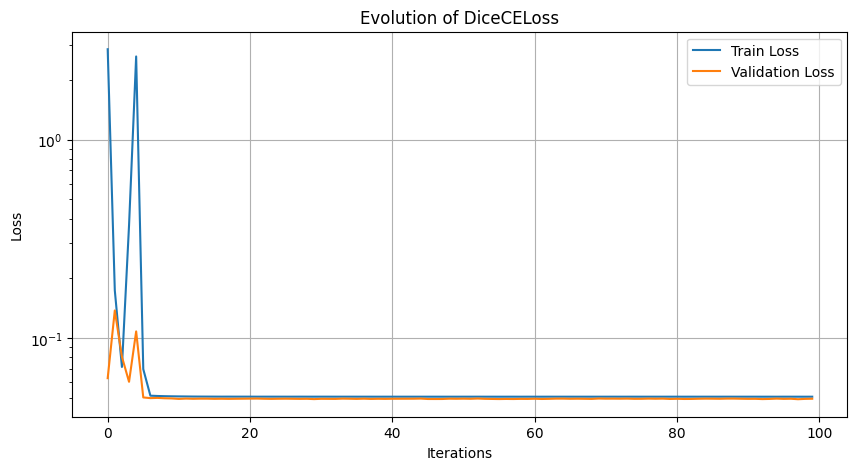

In [26]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Evolution of DiceCELoss')
plt.legend()
plt.grid()
plt.show()

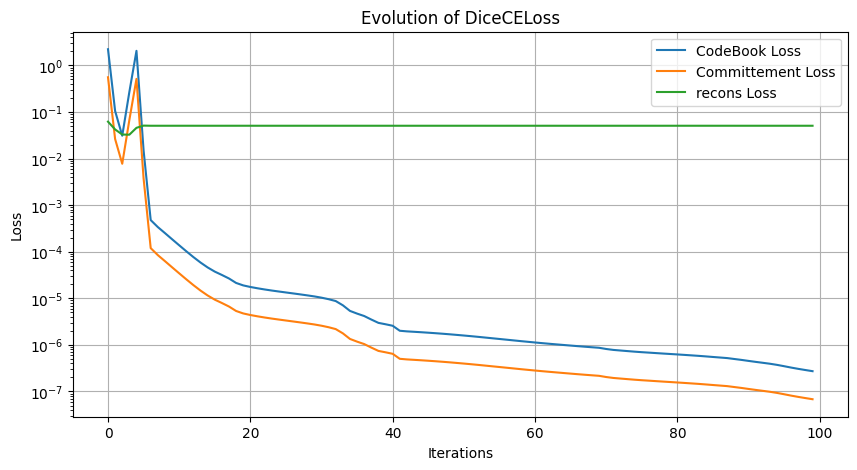

In [27]:
recons_loss_values = np.array(train_loss_values) - (np.array(commit_loss_values) + np.array(codebook_loss_values))
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
# plt.plot(train_loss_values, label='Train Loss')
# plt.plot(val_loss_values, label='Validation Loss')
plt.plot(codebook_loss_values, label = "CodeBook Loss")
plt.plot(commit_loss_values, label = "Committement Loss")
plt.plot(recons_loss_values, label = "recons Loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Evolution of DiceCELoss')
plt.legend()
plt.grid()
plt.show()

# Test ...

In [ ]:
model105 = VQVAE(in_channels, 64, 512)
model105.load_state_dict(torch.load('vqvae_105_bestmodel.pth')['model_state_dict'])
model105 = model105.to(device)

# batch_hat = torch.argmax(img_hat, dim = 1)




/tmp/ipykernel_237744/2425749840.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model105.load_state_dict(torch.load('vqvae_101_bestmodel.pth')['model_state_dict'])


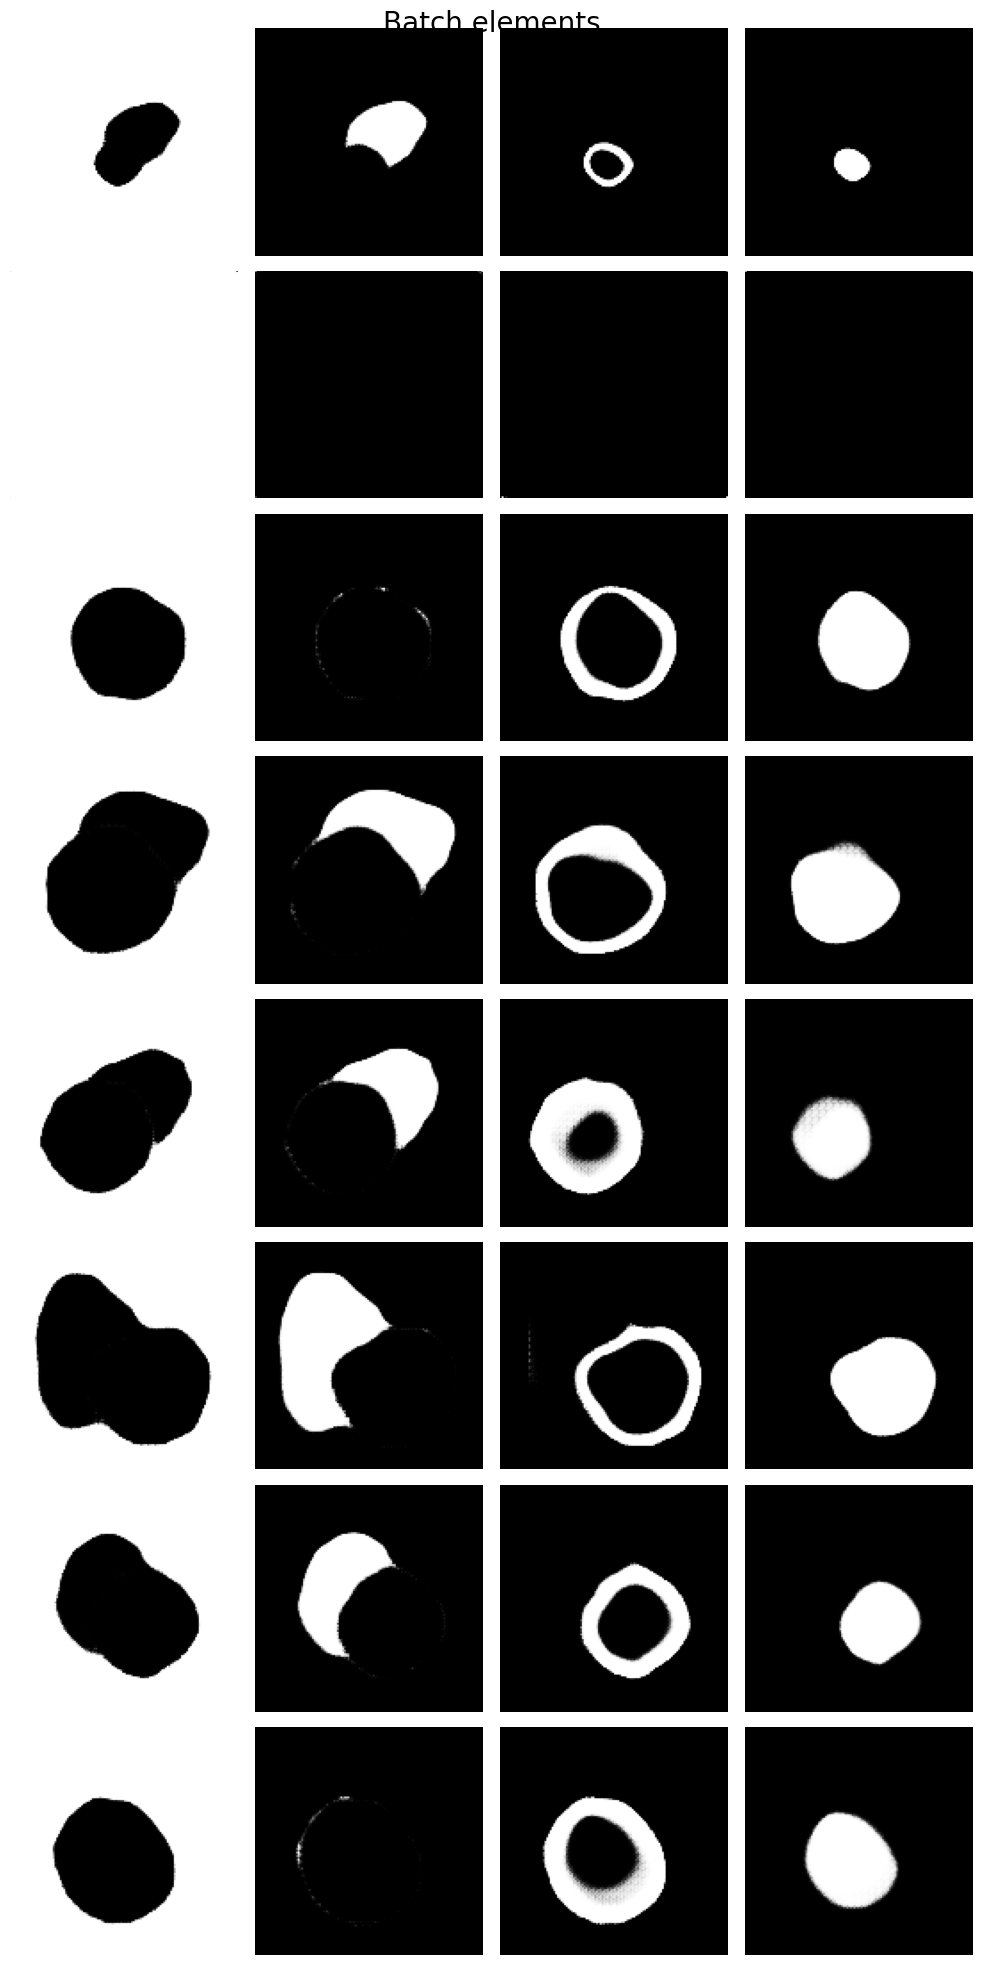

In [69]:
vis_batch = next(iter(TestLoader)).to(device)

batch_hat = reconstruct(vis_batch, model105)

visualize_batch( batch_hat.detach().cpu() )

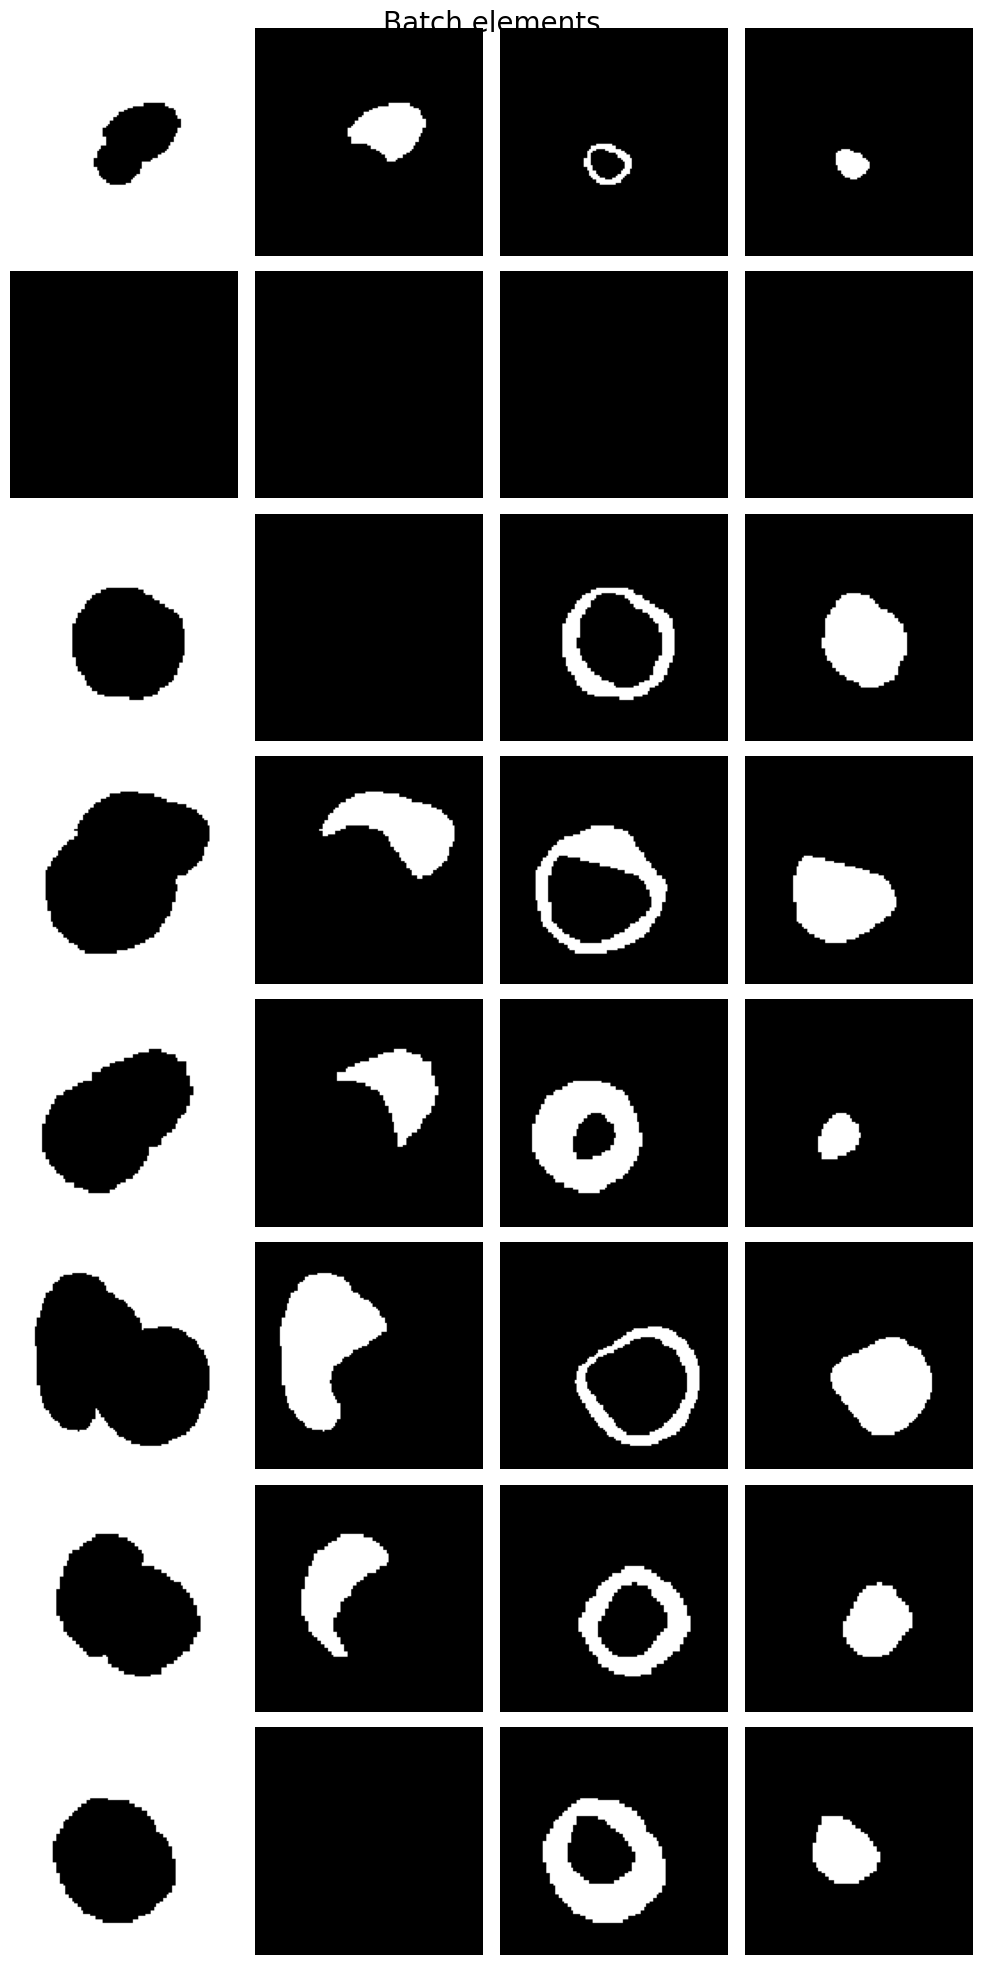

In [70]:
visualize_batch(vis_batch.detach().cpu())

In [41]:
len(recons_evolution)

10